<a href="https://colab.research.google.com/github/tienhuynh96/XGboost_Load_Forecasting/blob/main/XGboost_For_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting
## Using Machine Learning to Forecast Energy Consumption

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Types of Time Series Data

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/AIO_2023/Own Project/Load Forecasting with XGboost/PJME_hourly.csv')
# Get real data from a customer at Danang City
df = pd.read_csv('/content/drive/MyDrive/AIO_2023/Own Project/Load Forecasting with XGboost/PP05000506864.csv')

# Set time and comsumption (importkw)
df = df[['STARTTIME','IMPORTKW']]
# Set index is start ime
df = df.set_index('STARTTIME')
df.index = pd.to_datetime(df.index)
# Cut data time < '08-15-2023'
df = df.loc[df.index < '08-15-2023']
df.tail(5)

,IMPORTKW
STARTTIME,
2023-08-14 21:30:00,0.30920
2023-08-14 22:00:00,0.27944
2023-08-14 22:30:00,0.23736
2023-08-14 23:00:00,0.21400
2023-08-14 23:30:00,0.18032


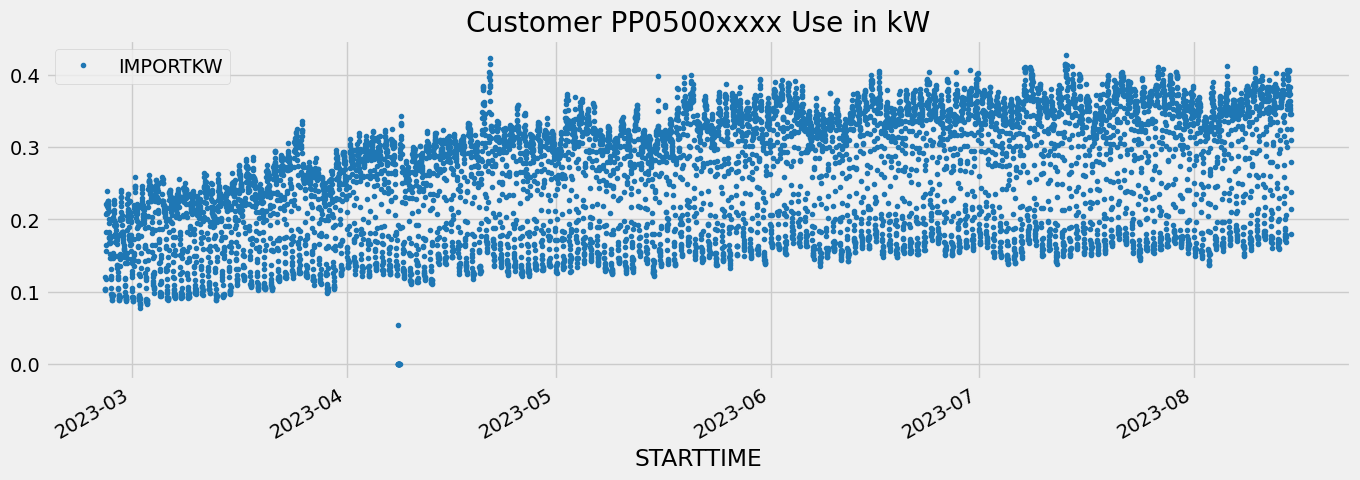

In [ ]:
# plot data
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Customer PP0500xxxx Use in kW')
plt.show()

# Train / Test Split

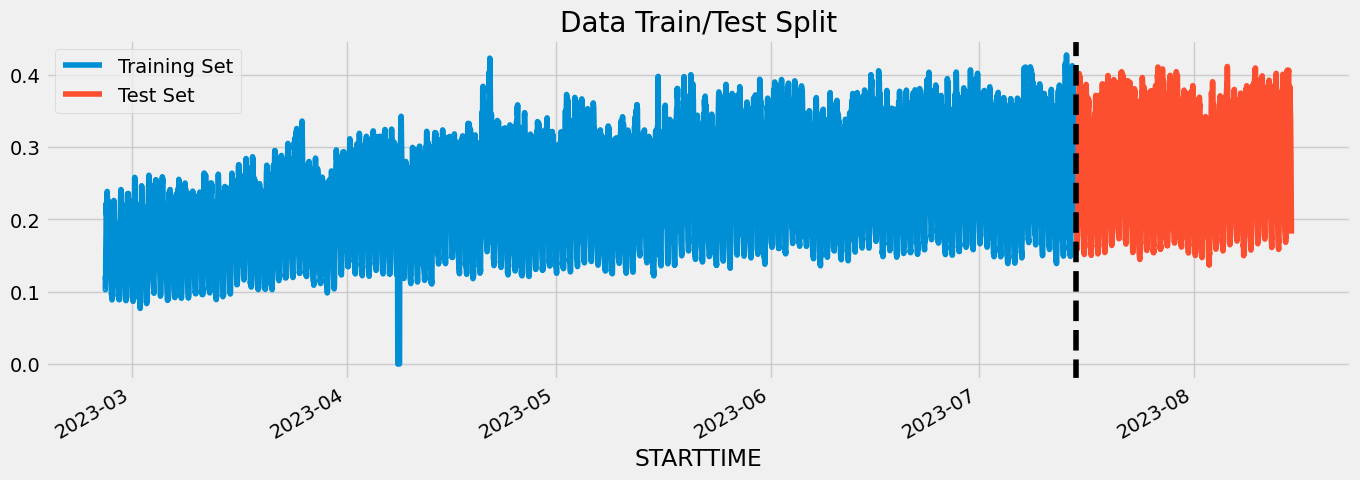

In [ ]:
# Cut data to train and test set
train = df.loc[df.index < '07-15-2023'] #mm-dd-yyyy
test = df.loc[df.index >= '07-15-2023']

# plot train and test set
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('07-15-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

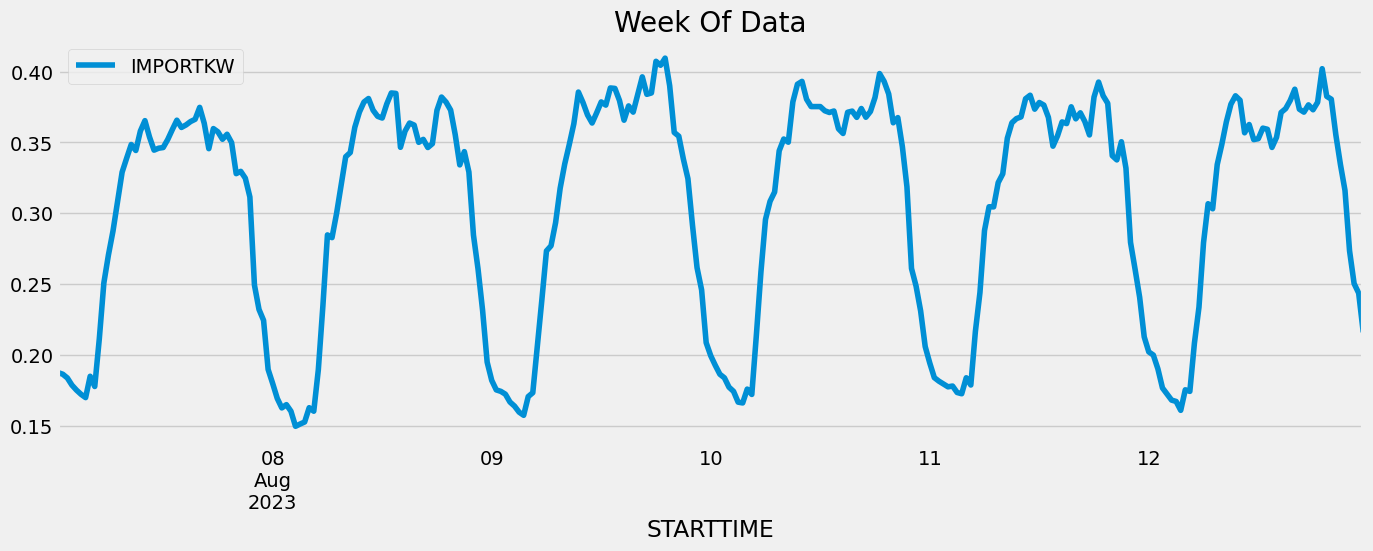

In [ ]:
df.loc[(df.index > '08-07-2023') & (df.index < '08-13-2023')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
df.head()

,IMPORTKW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
STARTTIME,,,,,,,,,
2023-02-25 02:30:00,0.10344,2,5,1,2,2023,56,25,8
2023-02-25 03:00:00,0.10376,3,5,1,2,2023,56,25,8
2023-02-25 03:30:00,0.10280,3,5,1,2,2023,56,25,8
2023-02-25 04:00:00,0.12104,4,5,1,2,2023,56,25,8
2023-02-25 04:30:00,0.11712,4,5,1,2,2023,56,25,8


# Visualize our Feature / Target Relationship

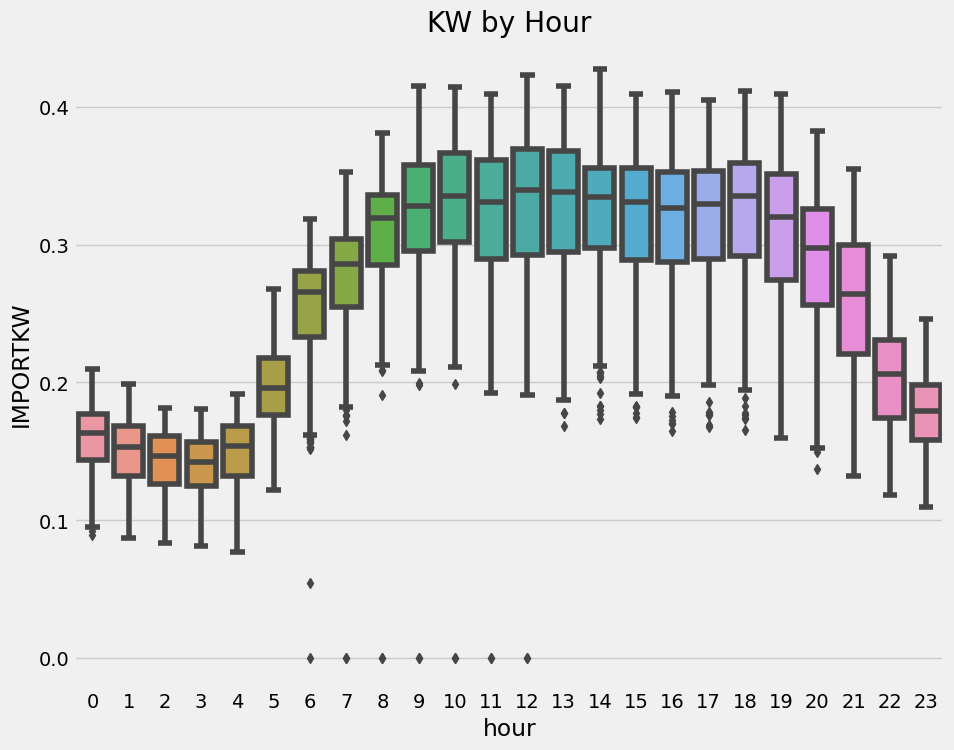

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='IMPORTKW')
ax.set_title('KW by Hour')
plt.show()

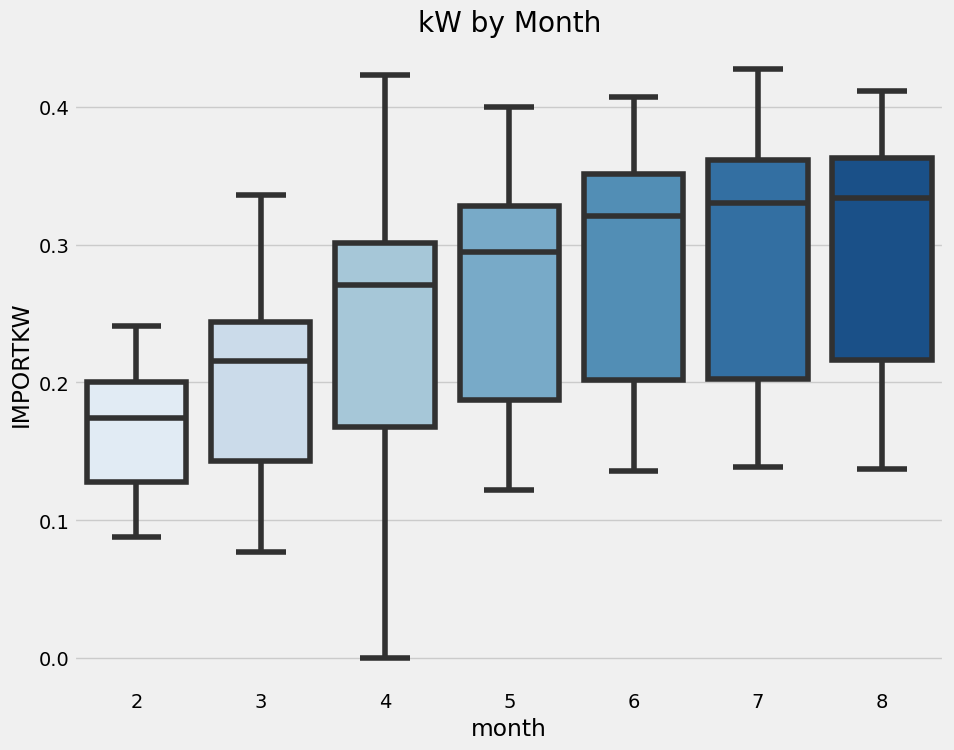

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='IMPORTKW', palette='Blues')
ax.set_title('kW by Month')
plt.show()

# Create our Model

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'IMPORTKW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# Set model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=10000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
# train
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[06:46:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.26043	validation_1-rmse:0.21621
[100]	validation_0-rmse:0.09933	validation_1-rmse:0.07246
[200]	validation_0-rmse:0.04275	validation_1-rmse:0.02762
[300]	validation_0-rmse:0.02584	validation_1-rmse:0.01984
[400]	validation_0-rmse:0.02173	validation_1-rmse:0.01870
[500]	validation_0-rmse:0.02059	validation_1-rmse:0.01829
[600]	validation_0-rmse:0.02001	validation_1-rmse:0.01773
[682]	validation_0-rmse:0.01964	validation_1-rmse:0.01786


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

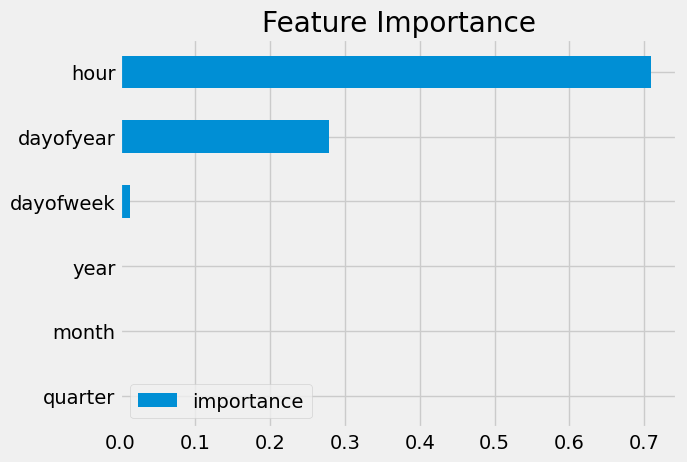

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

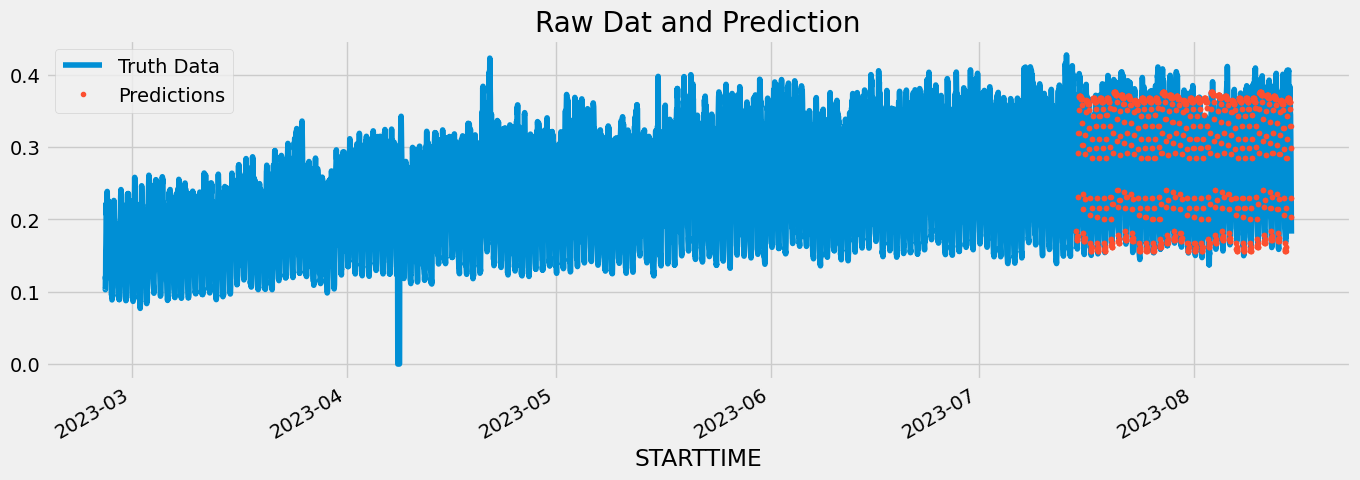

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['IMPORTKW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

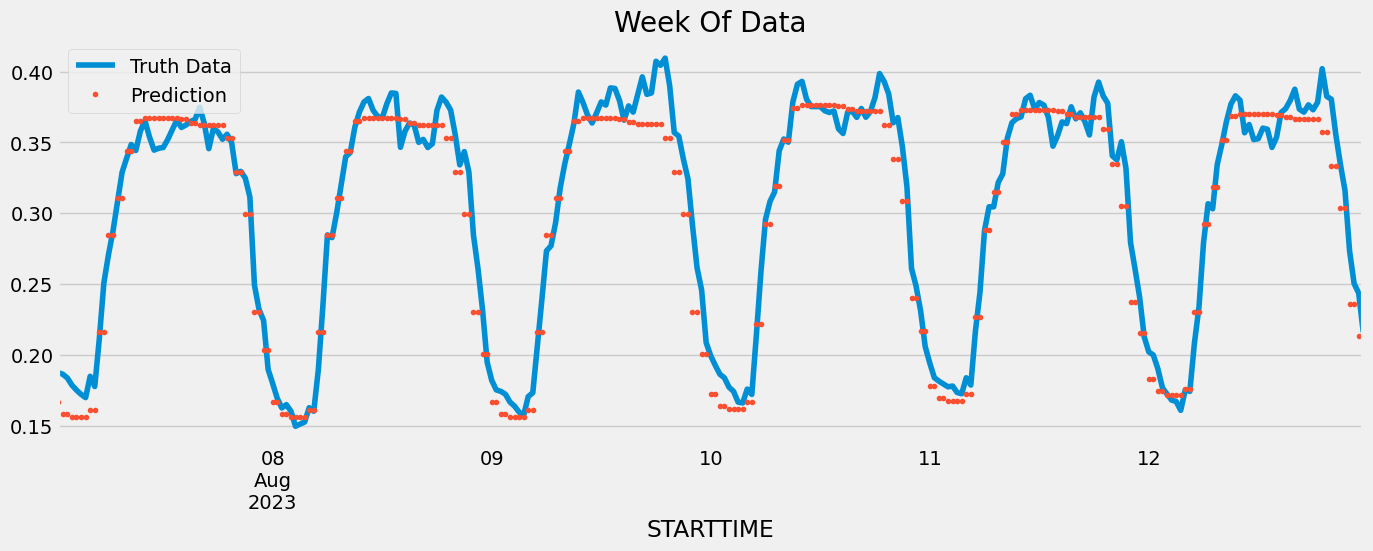

In [ ]:
ax = df.loc[(df.index > '08-07-2023') & (df.index < '08-13-2023')]['IMPORTKW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '08-07-2023') & (df.index < '08-13-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['IMPORTKW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.02


# Calculate Error
- Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-08-02    0.023227
2023-07-17    0.021802
2023-08-14    0.019968
2023-08-04    0.018318
2023-08-03    0.018126
2023-08-09    0.017970
2023-07-26    0.016970
2023-07-21    0.015541
2023-08-05    0.014106
2023-08-12    0.014012
Name: error, dtype: float64